In [9]:
import cv2 
import numpy as np
import os
import sys
import time
%matplotlib inline
from matplotlib import pyplot as plt


In [10]:
os.getcwd()
eva_dir = os.path.abspath('../../')
data_dir = os.path.join(eva_dir, 'data', 'videos')


In [ ]:
"""
This module performs input check
As video input, we expect decompressed format or compressed format

Function names: save_video(), help()

Input: will be filename or folder name
We expect the input to be a filename if compressed, we expect it to be folder name if decompressed

Output: np.array where shape will be n_samples, height, width, channels

If decompressed format, we expect a file structure where image files are located in the lowest level
We will 'walk' through all the folders given to generate the video where each folder level will be sorted

If compressed format, we will call the Decompression Module

After we make everything into the decompressed format and load all the images into np array, we will perform various type checks
1. Since images, we need the matrix be of type uint8
2. We need to make sure all the frame height, width matches (or at least we have to load them that way)

"""

In [5]:
os.getcwd()
os.path.isfile(os.getcwd())

False

In [40]:
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf
import sys

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping



os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [59]:
keras.backend.clear_session()

In [60]:
class CAENetwork:
    
    def __init__(self):
        
        self.autoencoder = None
        self.encoder = None
        self.width = 80 #requirements for this number must be that it needs to be divisible by 4
        self.height = 48 #must be divisible by 4
        self.image_array = None
        
    def _reform_input(self, image_table):
        # This function could rapidly change according to what we want
        # But the purpose of this function is to feed in the input as per network specifications
        # current specs: convert to size (48, 80) and grayscale
        start_time = time.time()
        assert(len(image_table.shape) == 4)
        assert(image_table.shape[3] == 3)
        n_samples = image_table.shape[0]
        self.image_array = np.ndarray(shape=(n_samples, self.height, self.width, 1))
        for i in range(len(image_table)):
            image = image_table[i,:,:,:]
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = cv2.resize(image, (self.width, self.height))
            #might need to expand dimension
            self.image_array[i,:,:,0] = image
        
        self.image_array /= 255.0 #normalize the input for layers
        print("finished reforming input, total time taken is", time.time() - start_time, "seconds")
        return

    
    def _build(self):
        #TODO:
        # Combined network with both FC and CNN layers
        
        # Input
        input_img = Input(shape=(self.height, self.width, 1))
        # Encoder
        x = Conv2D(8,(3,3),
                   activation='relu',
                   padding='same')(input_img)
        x = Conv2D(8,(3,3),
                   activation='relu',
                   padding='same')(x)
        x = MaxPooling2D((2,2),
                         padding='same')(x) 
        x = Conv2D(16,(3,3),
                   activation='relu',
                   padding='same')(x)
        x = Conv2D(16,(3,3),
                   activation='relu',
                   padding='same')(x)
        x = MaxPooling2D((2,2),
                         padding='same')(x) # Size 
        x = Flatten()(x)
        encoded = Dense(256)(x)
        # Decoder
        x = Dense(16*int(self.height / 4)*int(self.width / 4))(encoded)
        x = Reshape((int(self.height / 4), int(self.width / 4), 16))(x)
        x = UpSampling2D((2, 2))(x) # 24, 40, 16
        x = Conv2D(16, (3, 3),
                   activation='relu',
                   padding='same')(x)
        x = Conv2D(16, (3, 3),
                   activation='relu',
                   padding='same')(x)
        x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
        x = Conv2D(8, (3, 3),
                   activation='relu',
                   padding='same')(x)
        decoded = Conv2D(1, (3, 3),
                   activation='relu',
                   padding='same')(x)

        self.autoencoder = Model(input_img, decoded)
        self.encoder = Model(input_img, encoded)
        self.autoencoder.compile(optimizer='adam', loss='mse')
        self.autoencoder.summary()
        
        
        
    def train(self, image_table):
        self._reform_input(image_table)
        self._build()
        n_samples = len(self.image_array)
        X_train = self.image_array[:int(n_samples * 0.8)]
        X_val = self.image_array[int(n_samples * 0.8):]
         
        start_time = time.time()
        train_history = self.autoencoder.fit(X_train, X_train, epochs=200, batch_size=2048, validation_data=(X_val, X_val))
        print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")
      
    def get_compressed(self, image_table):
        self._reform_input(image_table)
        images_compressed = self.encoder.predict(self.image_array)
        return images_compressed
    
    def get_features(self, image_table):
        #TODO - Ujjwal and Shreya
        pass
    
    
    def evaluate(self):
        # This function is currently unsupported
        pass
    

In [11]:
class DecompressionModule:
    def __init__(self):
        self.vid_ = cv2.VideoCapture()
        self.image_matrix = None
        self.video_stats = {} #This will keep data of all the videos that have been parsed.. will not keep the image matrix only meta-data

    def reset(self):
        self.image_matrix = None

    def add_meta_data(self, path, frame_count, width, height, fps):
        self.video_stats[path] = {}
        self.video_stats[path]['fps'] = fps
        self.video_stats[path]['width'] = width
        self.video_stats[path]['height'] = height
        self.video_stats[path]['frame_count'] = frame_count

    def convert2images(self, path):
        self.vid_.open(path)
        frame_count = self.vid_.get(cv2.CAP_PROP_FRAME_COUNT)
        width = self.vid_.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = self.vid_.get(cv2.CAP_PROP_FRAME_HEIGHT)
        fps = self.vid_.get(cv2.CAP_PROP_FPS)
        channels = 3

        self.add_meta_data(path, frame_count, width, height, fps)

        assert (frame_count == int(frame_count))
        assert (width == int(width))
        assert (height == int(height))

        frame_count = int(frame_count)
        width = int(width)
        height = int(height)

        print(frame_count, height, width, channels)
        self.image_matrix = np.ndarray(shape=(frame_count, height, width, channels), dtype = np.uint8)

        for i in range(frame_count):
            success, image = self.vid_.read()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if not success:
                print("Image retrieval has failed")
            else:
                self.image_matrix[i, :, :, :] = image  # stored in rgb format
            

In [36]:
class VideoInputModule:
    
    def __init__(self):
        dc = DecompressionModule()
        self.image_array = None
        
    def _walk_directory(self, directory):
        # we will assume directory is the top folder that contains various subfolders
        assert(os.path.isdir(directory))
        
        all_directories = [directory]
        done = False
        
        while not done:
            curr_dir = all_directories[0]
            if os.path.isdir(curr_dir):
                curr_dir = all_directories.pop(0)
                curr_level = os.listdir(curr_dir)
                curr_level.sort()
                for sub in curr_level:
                    all_directories.append(os.path.join(curr_dir, sub))
            elif ('jpg' not in curr_dir) and ('jpeg' not in curr_dir) and ('png' not in curr_dir):
                #not a directory but also not a image file
                #we should never arrive here but added just for debugging purposes
                print("We have a non image file in the directory.. this is not allowed...")
                print(curr_dir)
                all_directories.pop(0)
                continue
            else:
                done = True

        print("Number of files to load:", len(all_directories))
        img_tmp = cv2.imread(all_directories[0], cv2.IMREAD_COLOR)
        height, width, channels = img_tmp.shape
        
        image_array = np.ndarray(shape=(len(all_directories), int(height), int(width), int(channels)), dtype = np.uint8)
        print(image_array.shape)
        
        for i in range(len(all_directories)):
            file_name = all_directories[i]
            img = cv2.imread(file_name,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image_array[i,:,:,:] = img

        print("Done!")
        return image_array
        
    def debug(self):
        from matplotlib import pyplot as plt
        import random
        fig=plt.figure(figsize=(10, 20))
        columns = 2
        rows = 10
        for idx in range(0, rows):
            fig.add_subplot(rows, columns, idx + 1)
            random_index = random.randint(0, len(self.image_array))
            original = np.copy(self.image_array[random_index])
            
            plt.imshow(original)
            
        plt.show()
        
    def get_image_array(self):
        return self.image_array
        
    
    def _convert_video_format(self, filename):
        if os.path.isfile(filename):
            print("given directory is a file..")
            self.image_array = dc.convert2images(filesname)
        elif os.path.isdir(filename):
            print("given directory is a folder...")
            self.image_array = self._walk_directory(filename)
        
        #TODO: Do some input checking
        #Make sure the array is uint8
        #Make sure the loaded image array is the same size as the asserted width / height
        
    
    def convert_video(self, filename):
        #filename should be file name if compressed video, if not it should be folder name
        self._convert_video_format(filename)
        
        
        

In [37]:
detrac_dir = os.path.join(eva_dir, 'data', 'ua_detrac', 'small-data')
vim_ = VideoInputModule()
vim_.convert_video(detrac_dir)


given directory is a folder...
Number of files to load: 10421
(10421, 540, 960, 3)
Done!


(10421, 540, 960, 3)


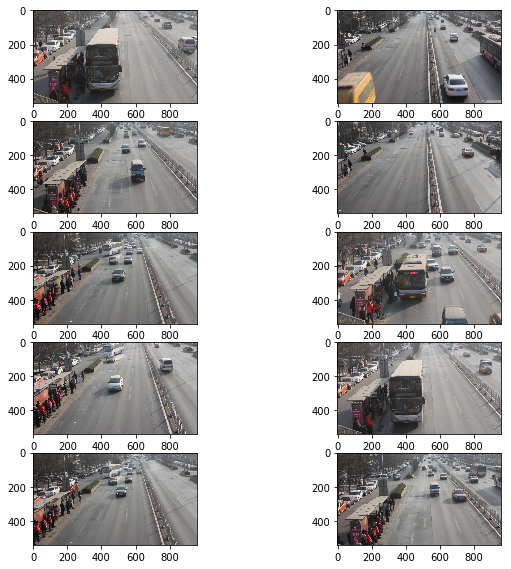

(10421, 540, 960, 3)


In [38]:

tmp = vim_.get_image_array()
print(tmp.shape)

vim_.debug()
image_table = vim_.get_image_array()
print(image_table.shape)

In [61]:
cae = CAENetwork()
cae.train(image_table)


finished reforming input, total time taken is 43.7044997215271 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 80, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 40, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 40, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 40, 16)        2320      
_________________________________________________________________
max_p

In [62]:
from sklearn.cluster import AgglomerativeClustering

#Assume you have compressed images: images_compressed
#original_images -> images_compressed (output of the encoder network)

class ClusterModule:
    
    def __init__(self):
        self.ac = None
        
    def evaluate(self, image_compressed, fps = 20):
        n_samples = len(image_compressed)
        self.ac = AgglomerativeClustering(n_clusters=n_samples // fps)
        start_time = time.time()
        self.ac.fit(image_compressed)
        print("Time to fit ", n_samples, ": ", time.time() - start_time)
        return self.ac.labels_
    
    def plot_distribution(self):
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
        axs.hist(self.ac.labels_, bins=max(self.ac.labels_) + 1)
        plt.xlabel("Cluster Numbers")
        plt.ylabel("Number of datapoints")



finished reforming input, total time taken is 43.36760377883911 seconds
Time to fit  10421 :  9.555643081665039


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


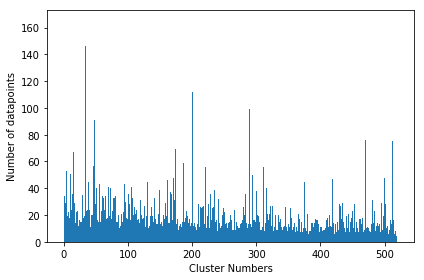

In [63]:
images_compressed = cae.get_compressed(image_table)

cm = ClusterModule()

image_labels = cm.evaluate(images_compressed)
cm.plot_distribution()